In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import statsmodels.api as sm

In [4]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [7]:
# Preprocess the data
df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])
df_summary['Weekday/Weekend'] = df_summary['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
df_summary.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5,Weekday/Weekend
0,2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0,1
1,2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0,1
2,2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0,1
3,2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0,1
4,2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0,1


In [162]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary = df_summary.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

# Loop through columns and replace negative values with zero
for col in df_summary.columns[1:7]:  # Adjust the column range as per your data
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')  # Convert column to numeric type
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero


df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])


df_i_summary = df_summary.set_index('Measurement date')


df_day_sum = df_i_summary[: '2019-12-31'].resample('D').mean()
df_day_sum.head()

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-01,0.005293,0.046432,0.004145,0.983500,77.203333,56.775000
2017-01-02,0.006040,0.039293,0.016460,0.894667,109.246667,77.843333
2017-01-03,0.005602,0.042017,0.013223,0.762167,78.551667,51.538333
2017-01-04,0.005788,0.050480,0.008585,0.880167,54.968333,34.535000
2017-01-05,0.004788,0.035558,0.011392,0.658000,36.248333,22.170000


In [163]:
# Group the data
df_day_sum.reset_index(inplace=True)

df_day_sum['Weekday/Weekend'] = df_day_sum['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
grouped_data = df_day_sum.groupby('Weekday/Weekend')

In [164]:
grouped_data.head()

,Measurement date,SO2,NO2,O3,CO,PM10,PM2.5,Weekday/Weekend
0,2017-01-01,0.005293,0.046432,0.004145,0.983500,77.203333,56.775000,1
1,2017-01-02,0.006040,0.039293,0.016460,0.894667,109.246667,77.843333,0
2,2017-01-03,0.005602,0.042017,0.013223,0.762167,78.551667,51.538333,0
3,2017-01-04,0.005788,0.050480,0.008585,0.880167,54.968333,34.535000,0
4,2017-01-05,0.004788,0.035558,0.011392,0.658000,36.248333,22.170000,0
5,2017-01-06,0.004458,0.035027,0.012730,0.530500,21.076667,13.256667,0
6,2017-01-07,0.005022,0.049277,0.004617,0.877667,53.938333,37.176667,1
7,2017-01-08,0.004412,0.031923,0.015080,0.589833,31.160000,21.726667,1
13,2017-01-14,0.003950,0.012817,0.023657,0.418833,43.903333,11.641667,1
14,2017-01-15,0.003973,0.021718,0.016118,1.079333,27.045000,13.593333,1


In [167]:
from scipy.stats import ttest_ind
# Perform statistical testing
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10','PM2.5']
for pollutant in pollutants:
    weekday_data = df_day_sum[df_day_sum['Weekday/Weekend'] == 0][pollutant]
    weekend_data = df_day_sum[df_day_sum['Weekday/Weekend'] == 1][pollutant]
    t_statistic, p_value = ttest_ind(weekday_data, weekend_data)
    
    # Step 6: Interpret the results
    if p_value < 0.05:
        print(f"There is some difference in {pollutant} levels between weekdays and weekends.")
    else:
        print(f"There is no significant difference in {pollutant} levels between weekdays and weekends.")

There is no significant difference in SO2 levels between weekdays and weekends.
There is no significant difference in NO2 levels between weekdays and weekends.
There is no significant difference in O3 levels between weekdays and weekends.
There is no significant difference in CO levels between weekdays and weekends.
There is no significant difference in PM10 levels between weekdays and weekends.
There is no significant difference in PM2.5 levels between weekdays and weekends.


<Figure size 800x600 with 0 Axes>

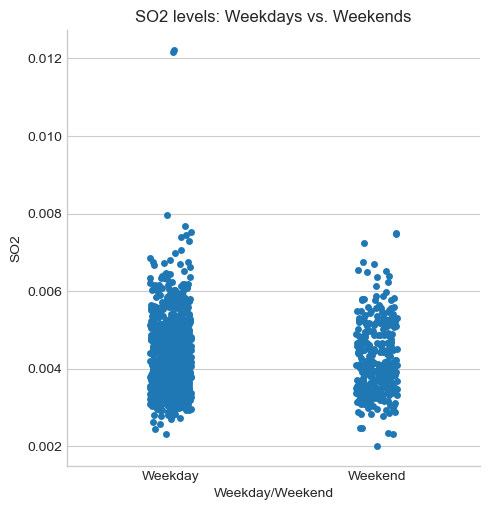

<Figure size 800x600 with 0 Axes>

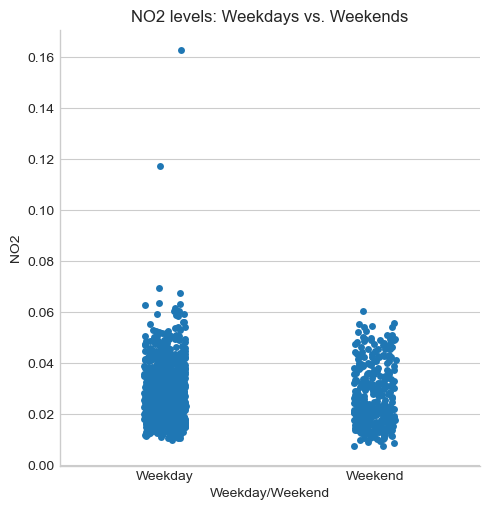

<Figure size 800x600 with 0 Axes>

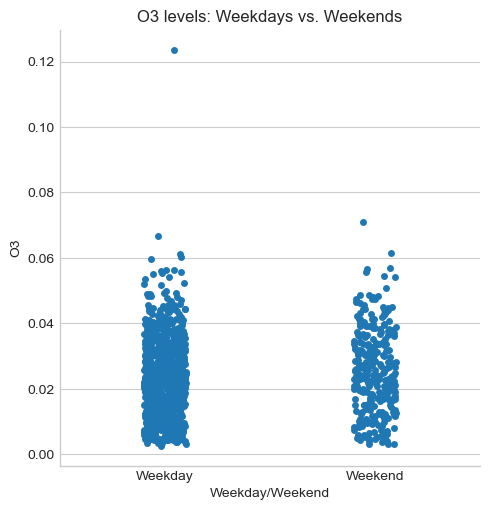

<Figure size 800x600 with 0 Axes>

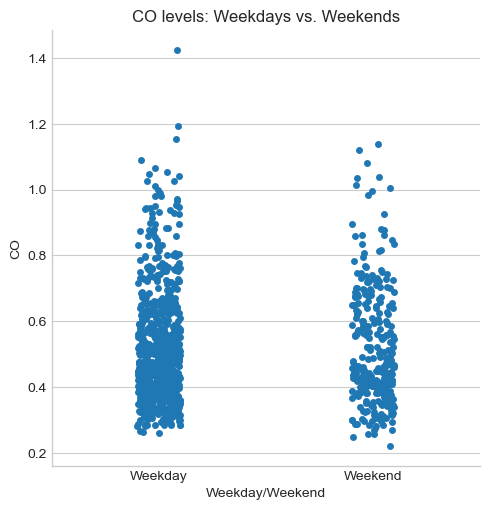

<Figure size 800x600 with 0 Axes>

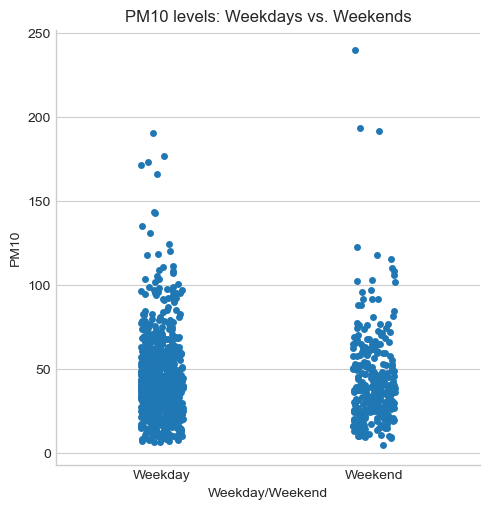

<Figure size 800x600 with 0 Axes>

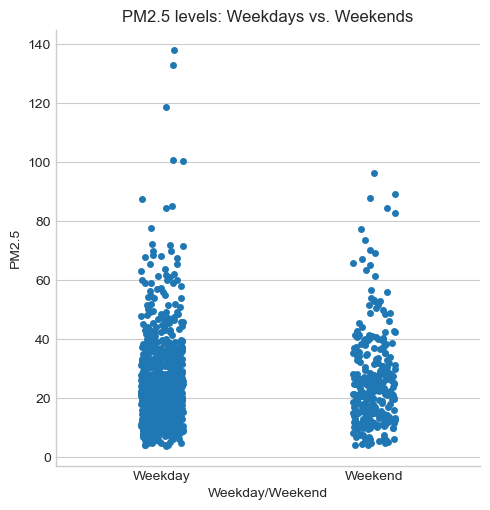

In [169]:
import seaborn as sns

for pollutant in pollutants:
    plt.figure(figsize=(8, 6))
    sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant)
    plt.xlabel('Weekday/Weekend')
    plt.ylabel(pollutant)
    plt.title(f'{pollutant} levels: Weekdays vs. Weekends')
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    plt.show()

In [2]:
df_summary = pd.read_csv('Measurement_summary.csv')

# Step 3: Preprocess the data
df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])
df_summary['Weekday/Weekend'] = df_summary['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
df_summary['Year'] = df_summary['Measurement date'].dt.year

# Step 4: Group the data and calculate mean values
grouped_data = df_summary.groupby(['Year', 'Weekday/Weekend']).mean()

# Step 5: Print the mean values
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

for pollutant in pollutants:
    print(f"Mean {pollutant} levels:")
    print(grouped_data[pollutant])
    print()

Mean SO2 levels:
Year  Weekday/Weekend
2017  0                  0.003271
      1                  0.003042
2018  0                 -0.001244
      1                 -0.000728
2019  0                 -0.007573
      1                 -0.008212
Name: SO2, dtype: float64

Mean NO2 levels:
Year  Weekday/Weekend
2017  0                  0.028445
      1                  0.026448
2018  0                  0.023715
      1                  0.022984
2019  0                  0.016559
      1                  0.014159
Name: NO2, dtype: float64

Mean O3 levels:
Year  Weekday/Weekend
2017  0                  0.022856
      1                  0.023719
2018  0                  0.017085
      1                  0.020638
2019  0                  0.011992
      1                  0.013810
Name: O3, dtype: float64

Mean CO levels:
Year  Weekday/Weekend
2017  0                  0.512895
      1                  0.530170
2018  0                  0.494409
      1                  0.494958
2019  0           

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/342623516.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df_summary.groupby(['Year', 'Weekday/Weekend']).mean()


In [3]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary = df_summary.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

# Loop through columns and replace negative values with zero
for col in df_summary.columns[1:7]:  # Adjust the column range as per your data
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')  # Convert column to numeric type
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero


df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])
df_i_summary = df_summary.set_index('Measurement date')

df_i_summary['2017']

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/434754543.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_i_summary['2017']


,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-01 00:00:00,0.004,0.059,0.002,1.2,73.0,57.0
2017-01-01 01:00:00,0.004,0.058,0.002,1.2,71.0,59.0
2017-01-01 02:00:00,0.004,0.056,0.002,1.2,70.0,59.0
2017-01-01 03:00:00,0.004,0.056,0.002,1.2,70.0,58.0
2017-01-01 04:00:00,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.005,0.024,0.020,0.5,33.0,19.0
2017-12-31 20:00:00,0.005,0.019,0.023,0.4,44.0,12.0
2017-12-31 21:00:00,0.005,0.026,0.018,0.5,42.0,18.0


In [ ]:
df_month_sum = df_i_summary[: '2019-12-31'].resample('M').mean()

In [80]:
df_month_sum.head()

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-31,0.005012,0.034788,0.014110,0.702651,52.752366,32.526935
2017-02-28,0.005055,0.034625,0.018249,0.634208,45.703214,28.546905
2017-03-31,0.005140,0.037669,0.024718,0.591720,59.455914,39.612527
2017-04-30,0.004966,0.031194,0.034605,0.504556,55.906278,26.234111
2017-05-31,0.005183,0.028162,0.038675,0.431543,62.747097,24.312634


In [83]:
df_sum_ser=validate_series(df_month_sum)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

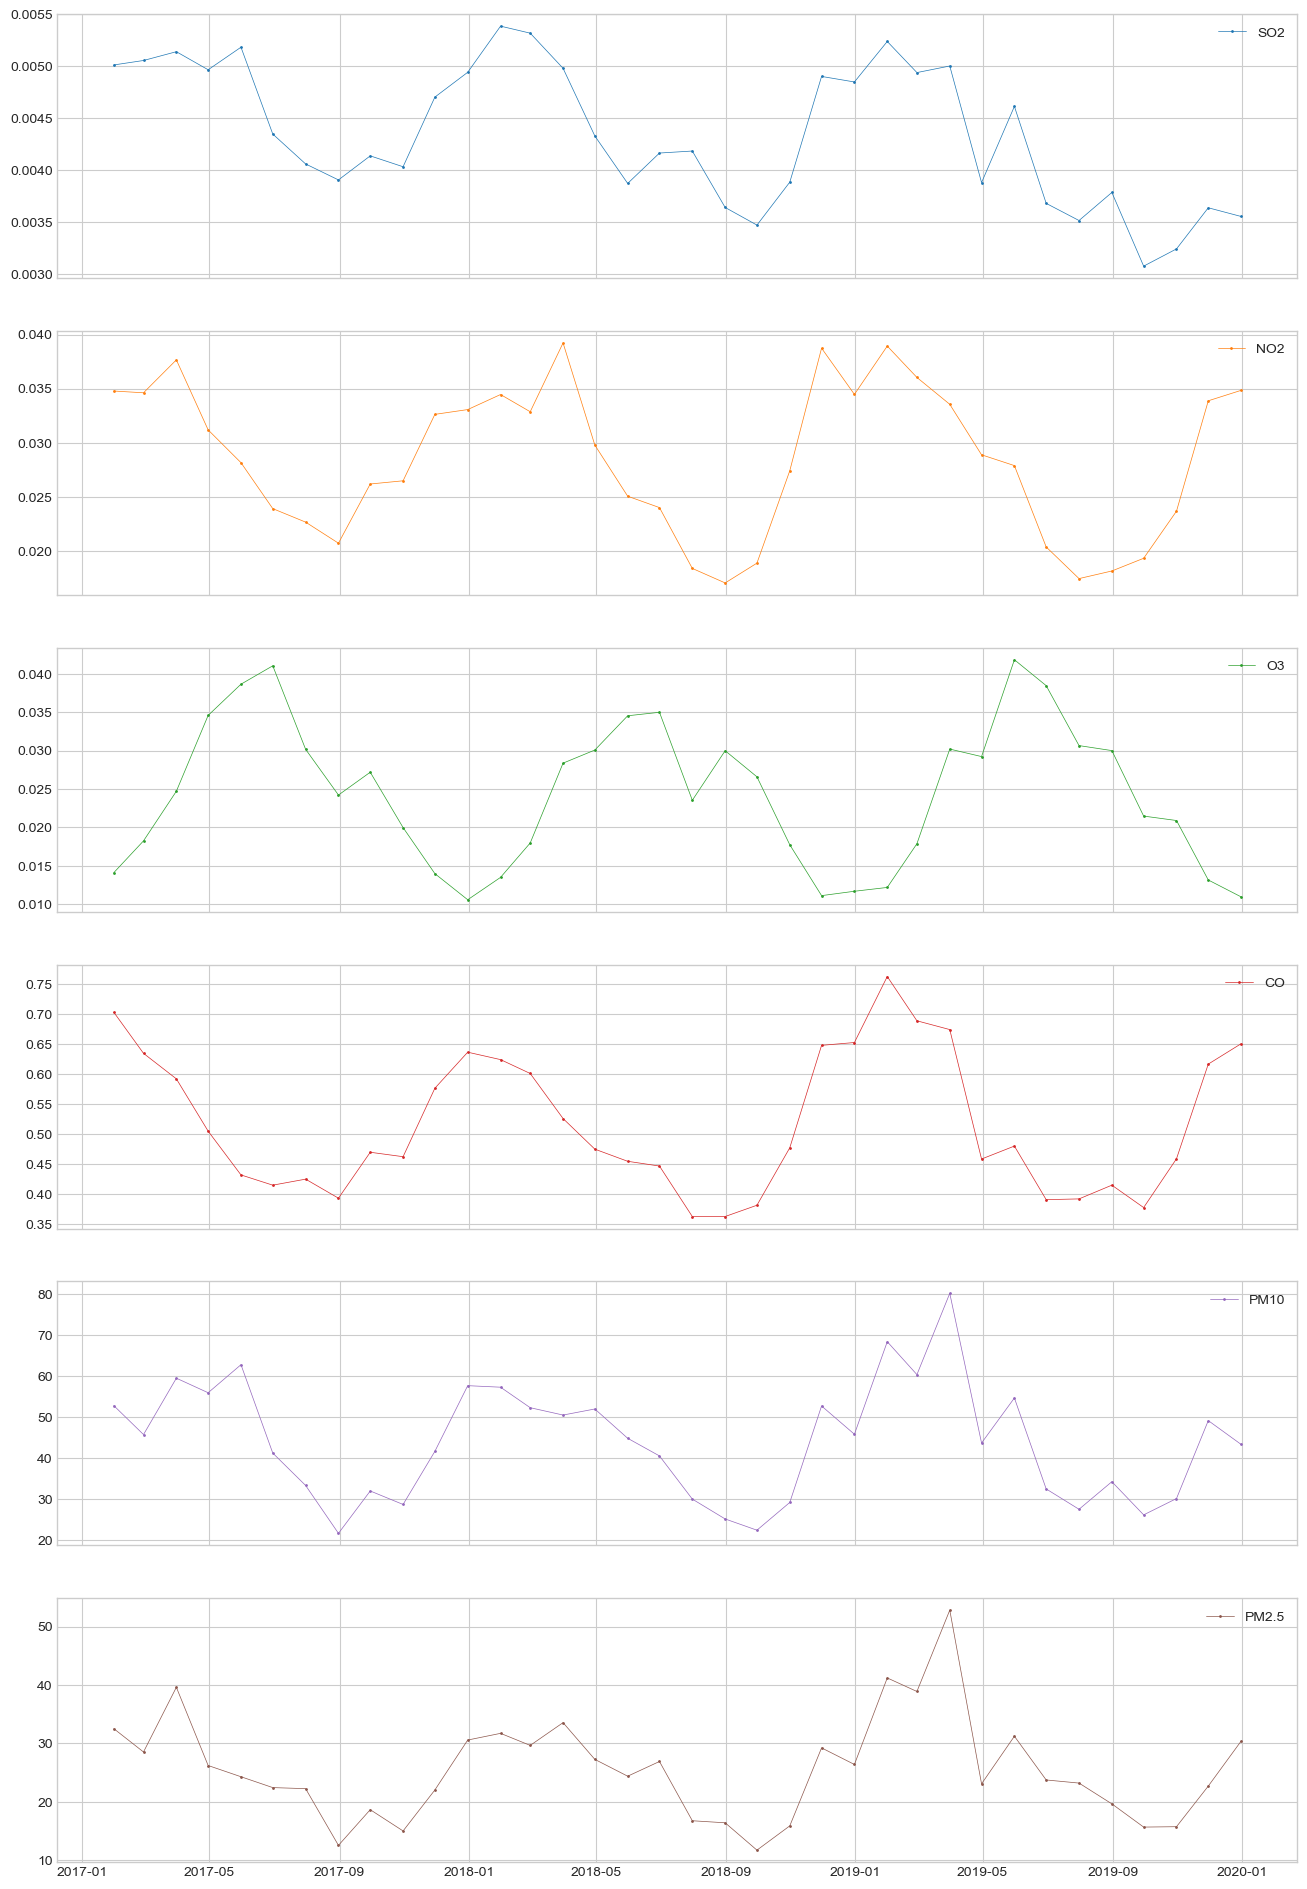

In [84]:
plot(df_sum_ser)

In [85]:
df_sum_ser.describe()

,SO2,NO2,O3,CO,PM10,PM2.5
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.004351,0.028486,0.024299,0.516897,44.016909,25.654282
std,0.000667,0.006903,0.009389,0.115031,14.154332,8.775422
min,0.003076,0.017042,0.010574,0.362204,21.608925,11.761778
25%,0.003850,0.023425,0.016832,0.422025,31.481829,19.425715
50%,0.004256,0.028526,0.024470,0.475686,44.220992,24.359462
75%,0.004969,0.034467,0.030193,0.626387,53.222022,30.452548
max,0.005386,0.039234,0.041861,0.762240,80.151095,52.802650


array([[<Axes: title={'center': 'SO2'}>, <Axes: title={'center': 'NO2'}>],
       [<Axes: title={'center': 'O3'}>, <Axes: title={'center': 'CO'}>],
       [<Axes: title={'center': 'PM10'}>,
        <Axes: title={'center': 'PM2.5'}>]], dtype=object)

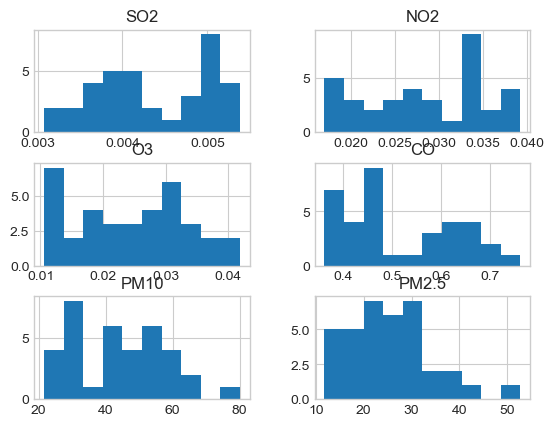

In [86]:
df_sum_ser.hist()

In [278]:
['SO2', 'NO2', 'O3', 'CO', 'PM10']
df_SO2_sum = df_sum_ser.drop(['NO2', 'O3', 'CO', 'PM10', 'PM2.5'], axis=1)
df_NO2_sum = df_sum_ser.drop(['SO2', 'O3', 'CO', 'PM10', 'PM2.5' ], axis=1)
df_O3_sum = df_sum_ser.drop(['SO2', 'NO2', 'CO', 'PM10', 'PM2.5'], axis=1)
df_CO_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'PM10', 'PM2.5'], axis=1)
df_PM10_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'CO', 'PM2.5'], axis=1)
df_PM2_5_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'CO', 'PM10'], axis=1)

/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


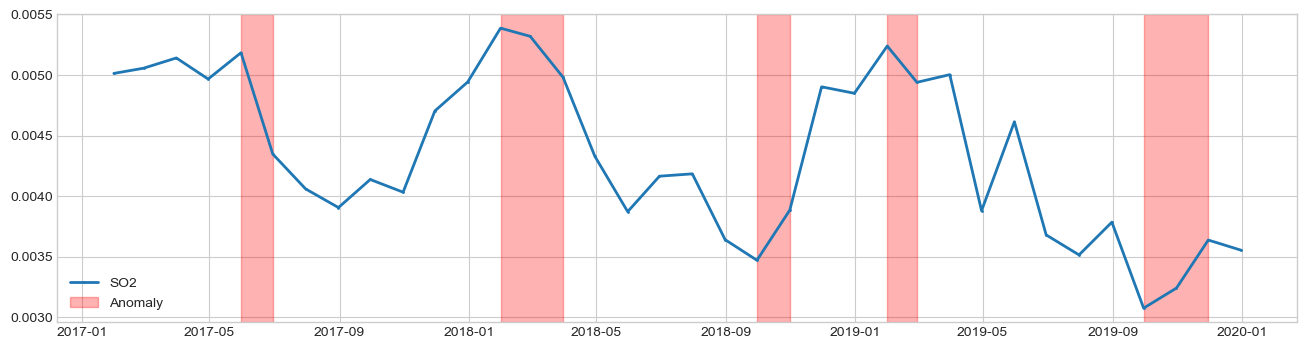

In [92]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.2))
anomalies_SO2 = outlier_detector.fit_detect(df_SO2_sum)
plot(df_SO2_sum, anomaly=anomalies_SO2, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

[<Axes: >]

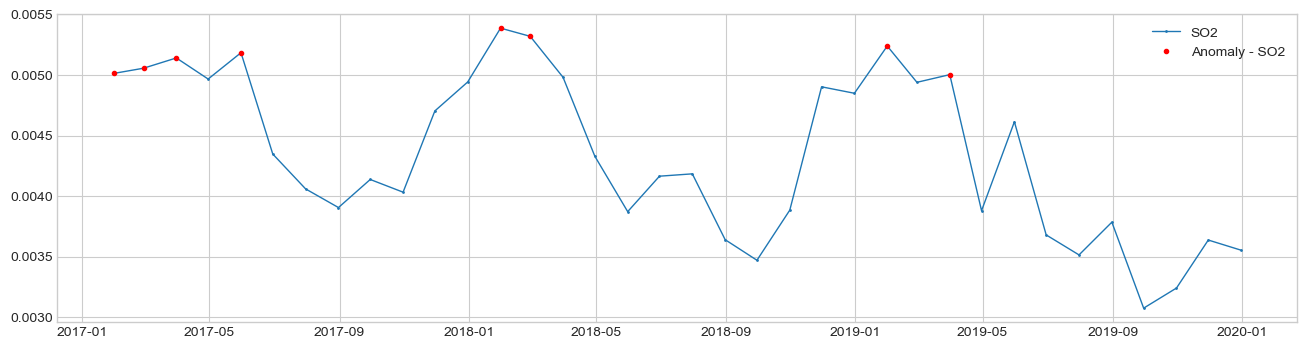

In [95]:
threshold = ThresholdAD(high=0.005, low=0.003)
anomalies_SO2 = threshold.detect(df_SO2_sum)
plot(df_SO2_sum, anomaly=anomalies_SO2, ts_linewidth=1, anomaly_markersize=3, anomaly_color='red', anomaly_tag='marker')

In [96]:
anomalies_SO2[anomalies_SO2.SO2]

,SO2
Measurement date,
2017-01-31,True
2017-02-28,True
2017-03-31,True
2017-05-31,True
2018-01-31,True
2018-02-28,True
2019-01-31,True
2019-03-31,True


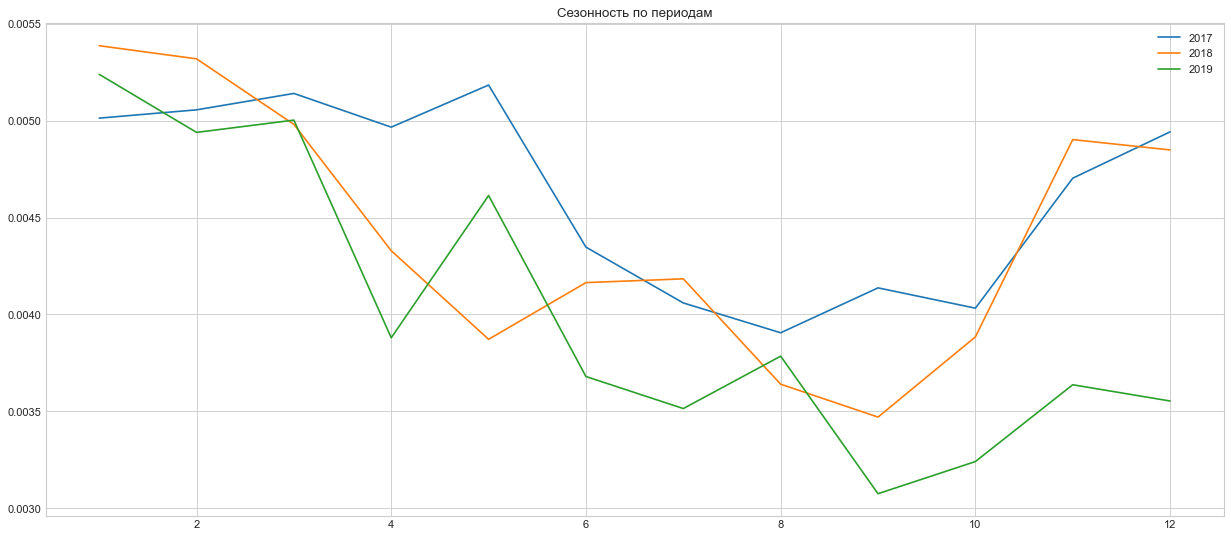

In [97]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_SO2_sum, 12)

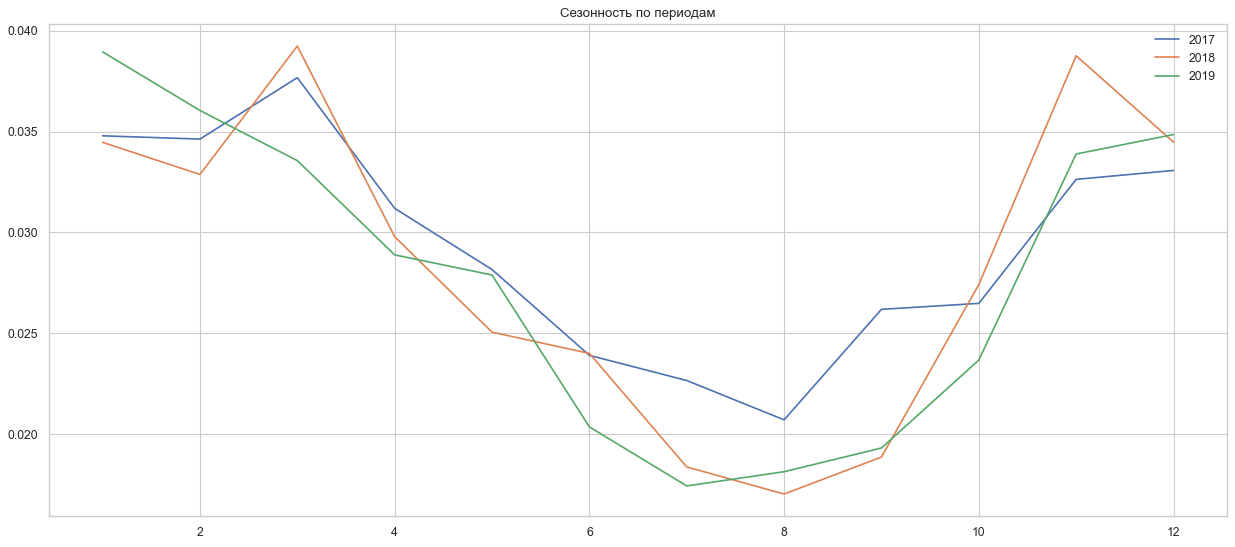

In [240]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_NO2_sum, 12)

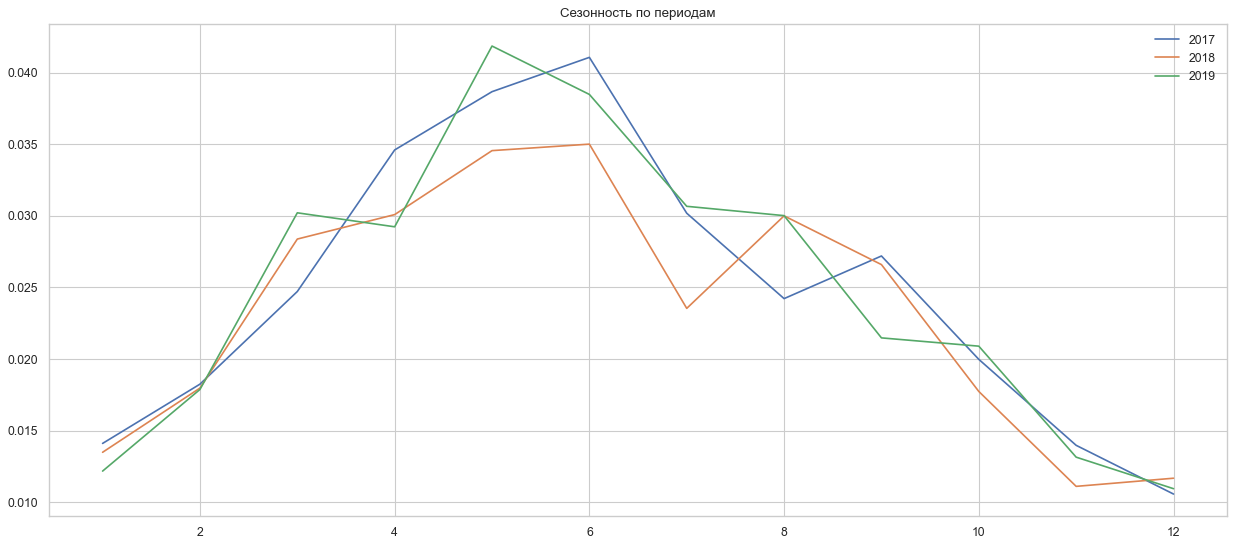

In [241]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_O3_sum, 12)

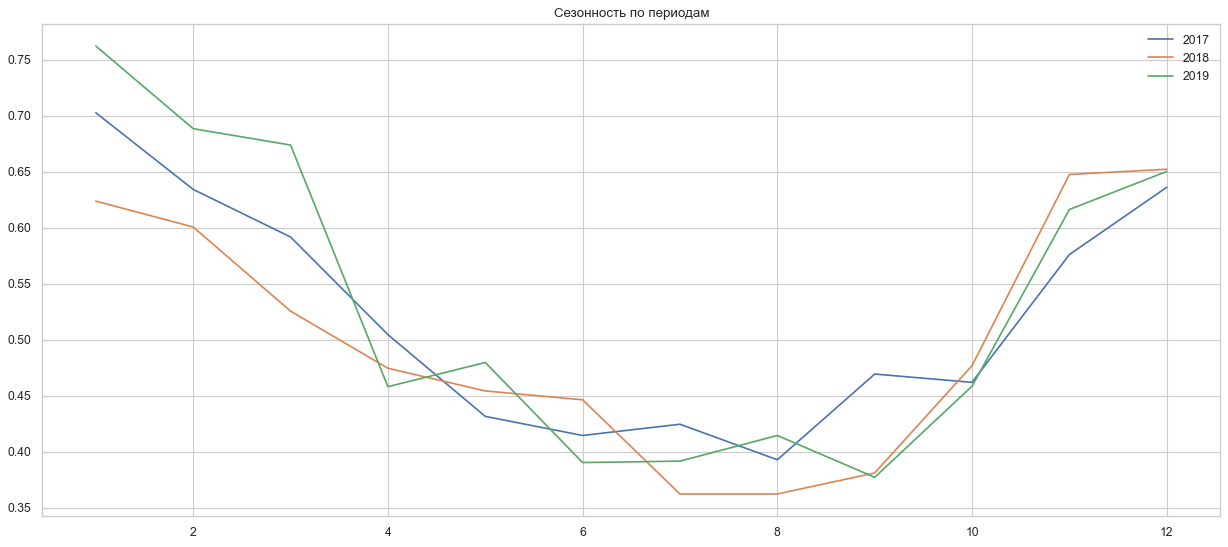

In [242]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_CO_sum, 12)

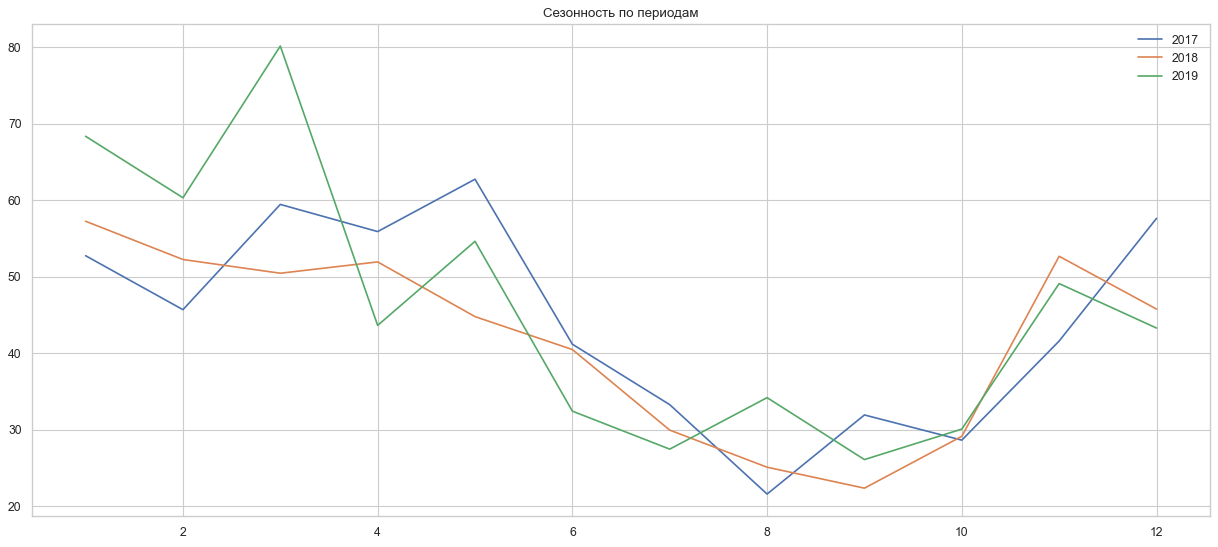

In [243]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_PM10_sum, 12)

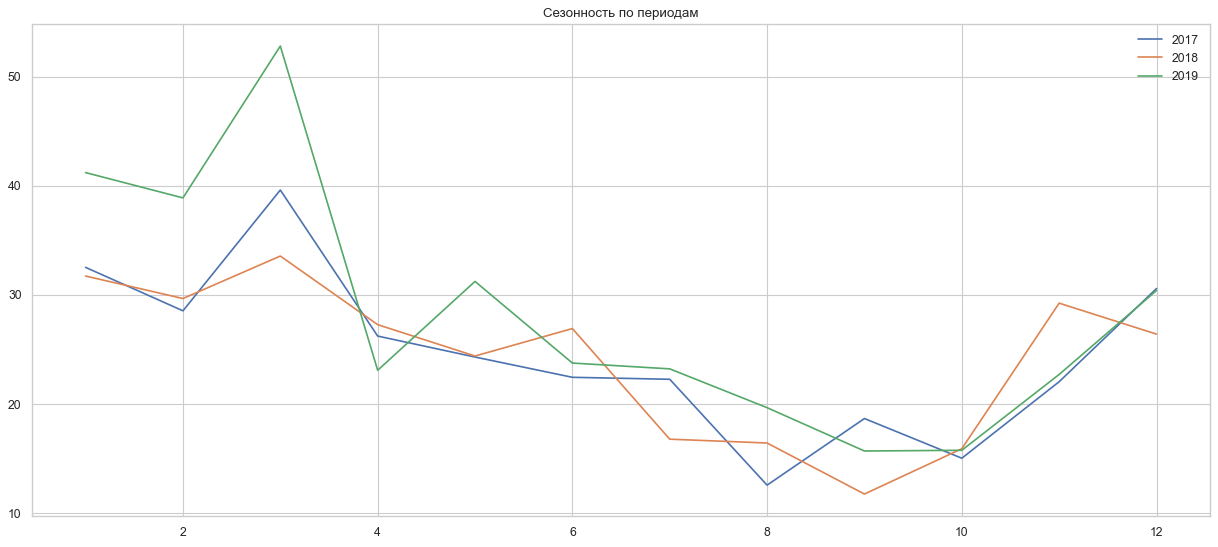

In [244]:
# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_PM2_5_sum, 12)

Text(0.5, 0.98, 'Мультипликативная модель')

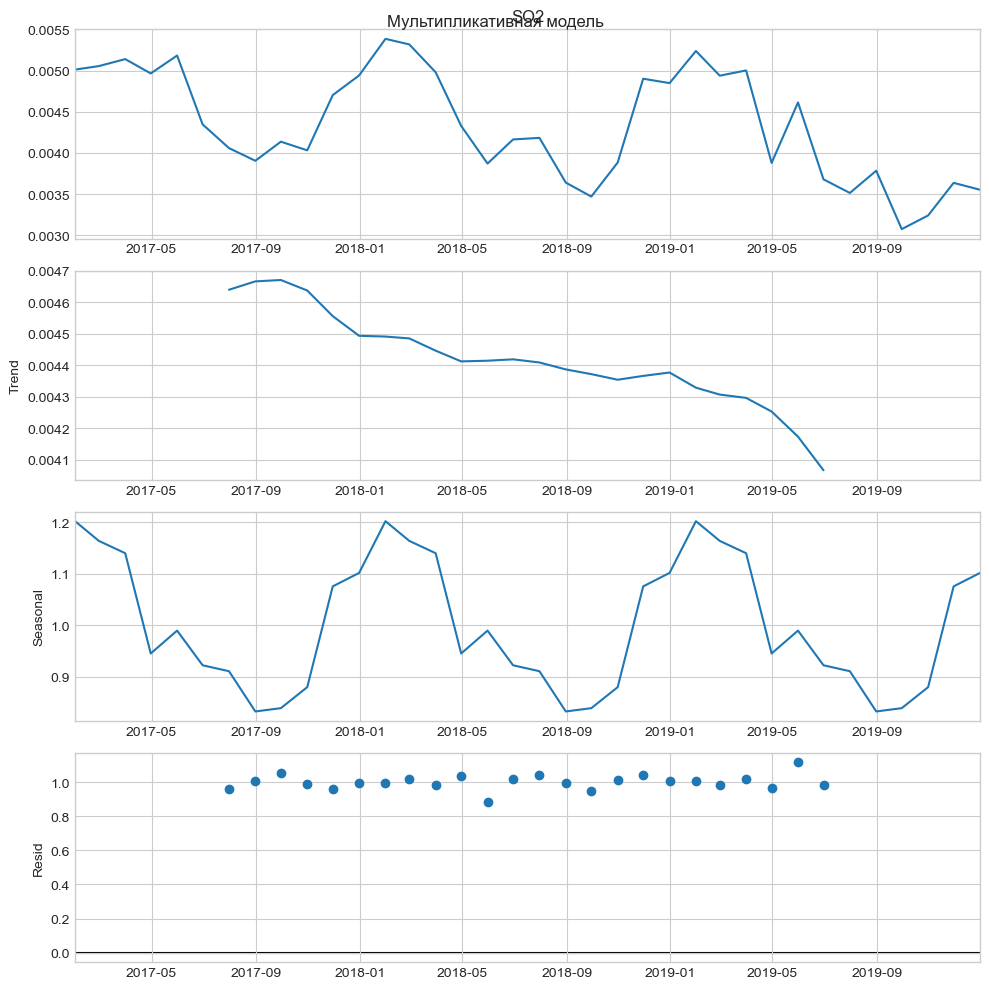

In [98]:
# декомпозиция
result_M_SO2 = seasonal_decompose(df_SO2_sum.SO2, model='multiplicative', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M_SO2.plot().suptitle('Мультипликативная модель')

In [99]:
result_M_SO2.seasonal['2017']

Measurement date
2017-01-31    1.202474
2017-02-28    1.164093
2017-03-31    1.140061
2017-04-30    0.944872
2017-05-31    0.989394
2017-06-30    0.921899
2017-07-31    0.910336
2017-08-31    0.831967
2017-09-30    0.838380
2017-10-31    0.879289
2017-11-30    1.075505
2017-12-31    1.101730
Freq: M, Name: seasonal, dtype: float64

Text(0.5, 0.98, 'Адитивная модель')

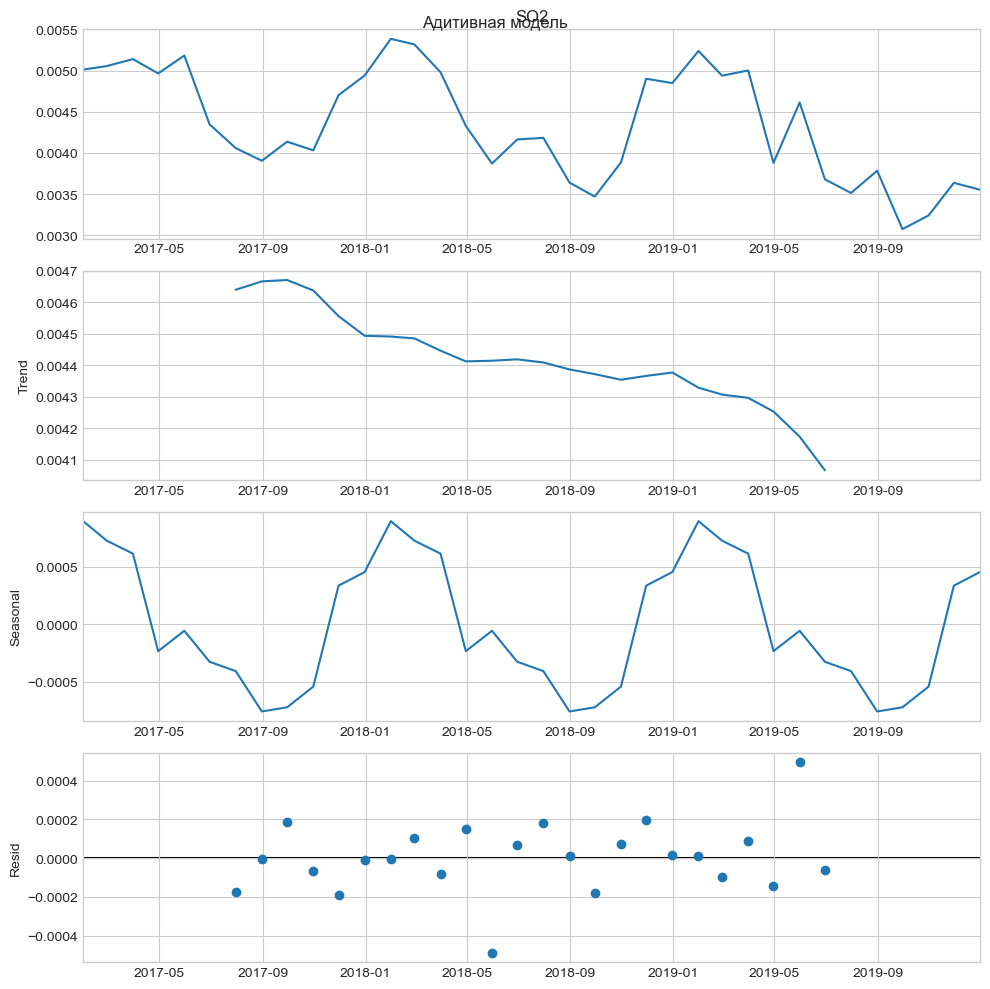

In [100]:
# Decompose
result_A_SO2 = seasonal_decompose(df_SO2_sum.SO2, model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A_SO2.plot().suptitle('Адитивная модель')

In [101]:
result_A_SO2.seasonal['2017']

Measurement date
2017-01-31    0.000898
2017-02-28    0.000729
2017-03-31    0.000616
2017-04-30   -0.000232
2017-05-31   -0.000055
2017-06-30   -0.000325
2017-07-31   -0.000406
2017-08-31   -0.000757
2017-09-30   -0.000721
2017-10-31   -0.000541
2017-11-30    0.000338
2017-12-31    0.000456
Freq: M, Name: seasonal, dtype: float64

In [120]:
fit_SO2 = ExponentialSmoothing(df_SO2_sum, seasonal_periods=12, trend='mul', seasonal='add').fit()

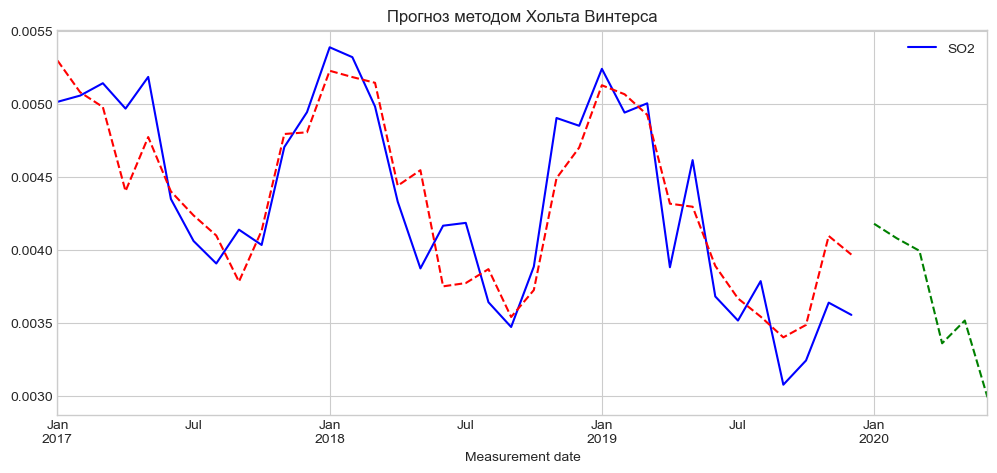

In [122]:
ax = df_SO2_sum.plot(figsize=(12,5), color='blue', title="Прогноз методом Хольта Винтерса" )
fit_SO2.fittedvalues.plot(ax=ax, style='--', color='red')
fit_SO2.forecast(6).plot(ax=ax, style='--', color='green')
plt.show()

In [123]:
fit_SO2.params

{'smoothing_level': 0.39392857454734304,
 'smoothing_trend': 9.99284821588407e-05,
 'smoothing_seasonal': 9.993432469443782e-05,
 'damping_trend': nan,
 'initial_level': 0.004620262771944509,
 'initial_trend': 0.9935701563466728,
 'initial_seasons': array([ 7.04633660e-04,  6.27498412e-04,  5.64087949e-04, -4.72480974e-05,
         1.30498491e-04, -3.73135603e-04, -4.86563388e-04, -5.25133397e-04,
        -7.36041247e-04, -4.97456999e-04,  2.32467533e-04,  3.08270296e-04]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [124]:
fit_SO2.fittedvalues

Measurement date
2017-01-31    0.005295
2017-02-28    0.005078
2017-03-31    0.004977
2017-04-30    0.004401
2017-05-31    0.004771
2017-06-30    0.004399
2017-07-31    0.004235
2017-08-31    0.004097
2017-09-30    0.003782
2017-10-31    0.004130
2017-11-30    0.004792
2017-12-31    0.004804
2018-01-31    0.005225
2018-02-28    0.005182
2018-03-31    0.005143
2018-04-30    0.004438
2018-05-31    0.004544
2018-06-30    0.003749
2018-07-31    0.003772
2018-08-31    0.003867
2018-09-30    0.003539
2018-10-31    0.003724
2018-11-30    0.004489
2018-12-31    0.004699
2019-01-31    0.005126
2019-02-28    0.005064
2019-03-31    0.004923
2019-04-30    0.004315
2019-05-31    0.004294
2019-06-30    0.003889
2019-07-31    0.003666
2019-08-31    0.003542
2019-09-30    0.003400
2019-10-31    0.003485
2019-11-30    0.004094
2019-12-31    0.003966
Freq: M, dtype: float64

In [125]:
fit_SO2.forecast(6)

2020-01-31    0.004178
2020-02-29    0.004078
2020-03-31    0.003993
2020-04-30    0.003359
2020-05-31    0.003515
2020-06-30    0.002990
Freq: M, dtype: float64

Text(0.5, 0.98, 'Мультипликативная модель')

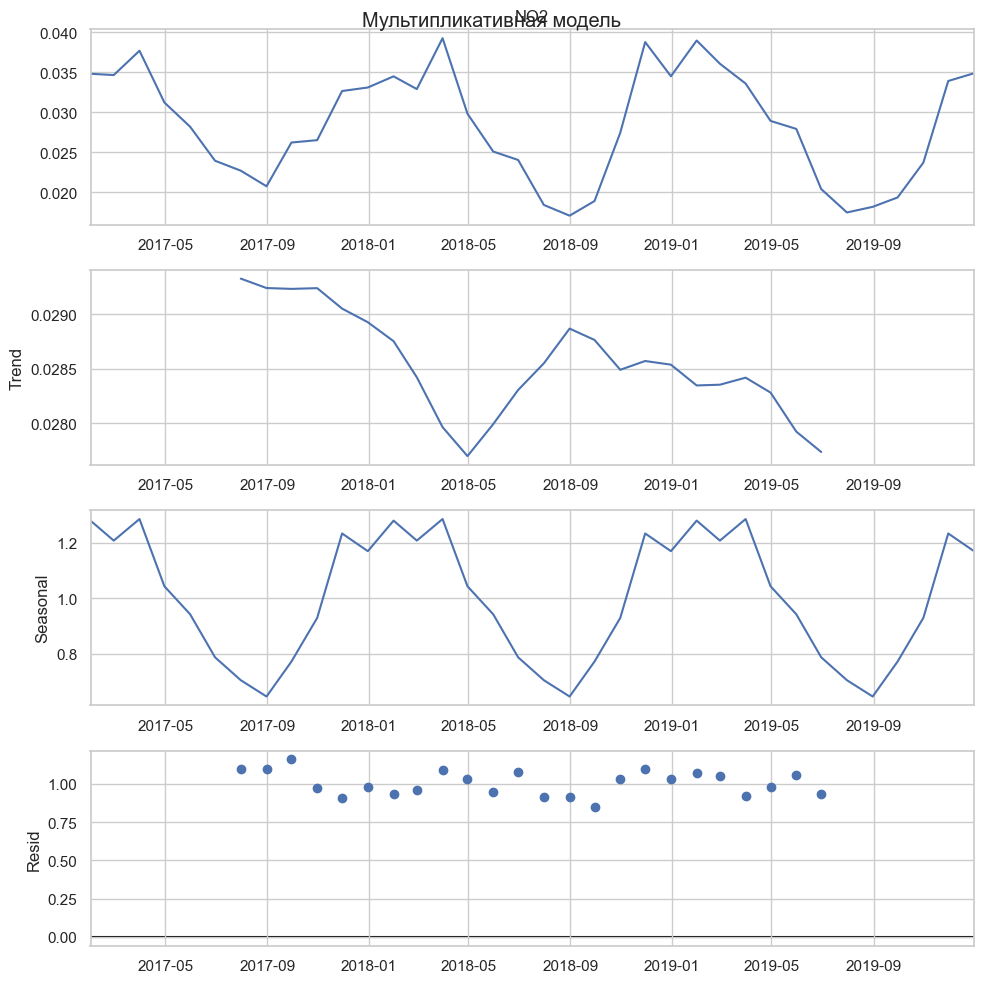

In [254]:
# декомпозиция
result_M_NO2 = seasonal_decompose(df_NO2_sum.NO2, model='multiplicative', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M_NO2.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Мультипликативная модель')

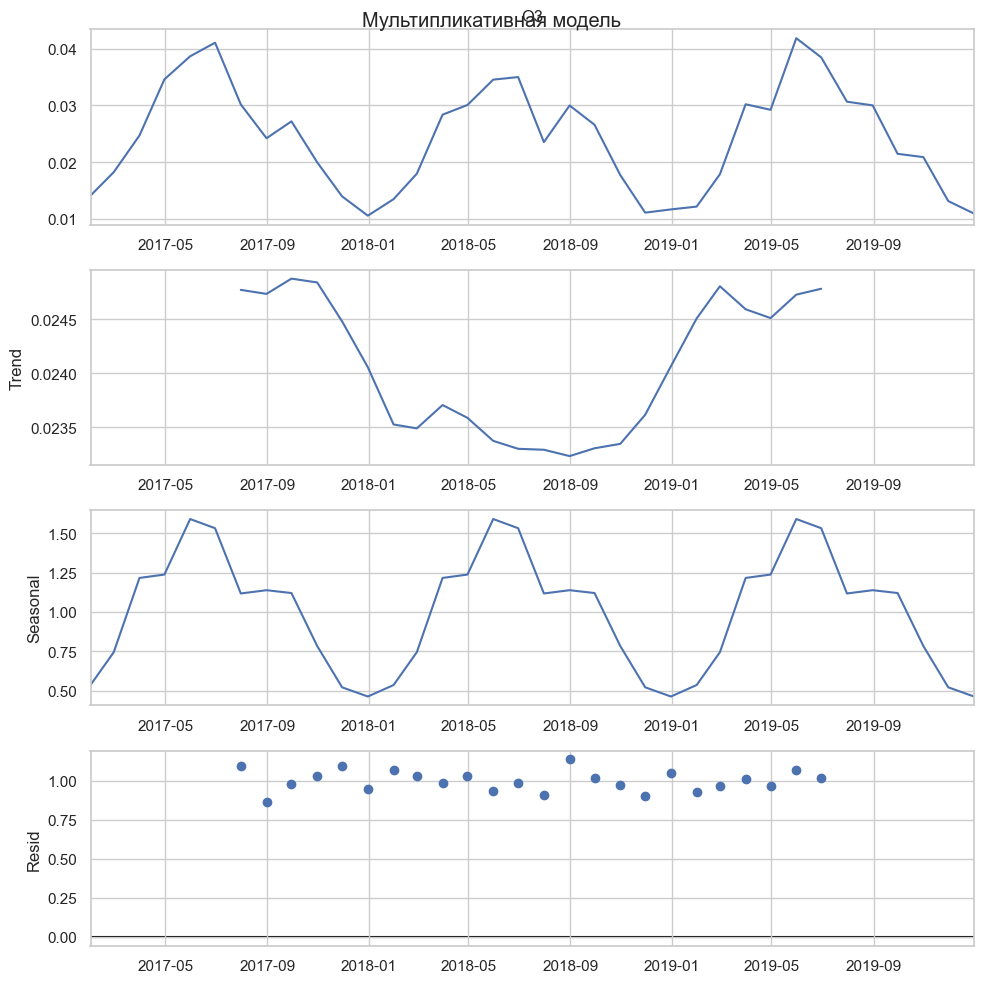

In [255]:
# декомпозиция
result_M_O3 = seasonal_decompose(df_O3_sum.O3, model='multiplicative', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M_O3.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Мультипликативная модель')

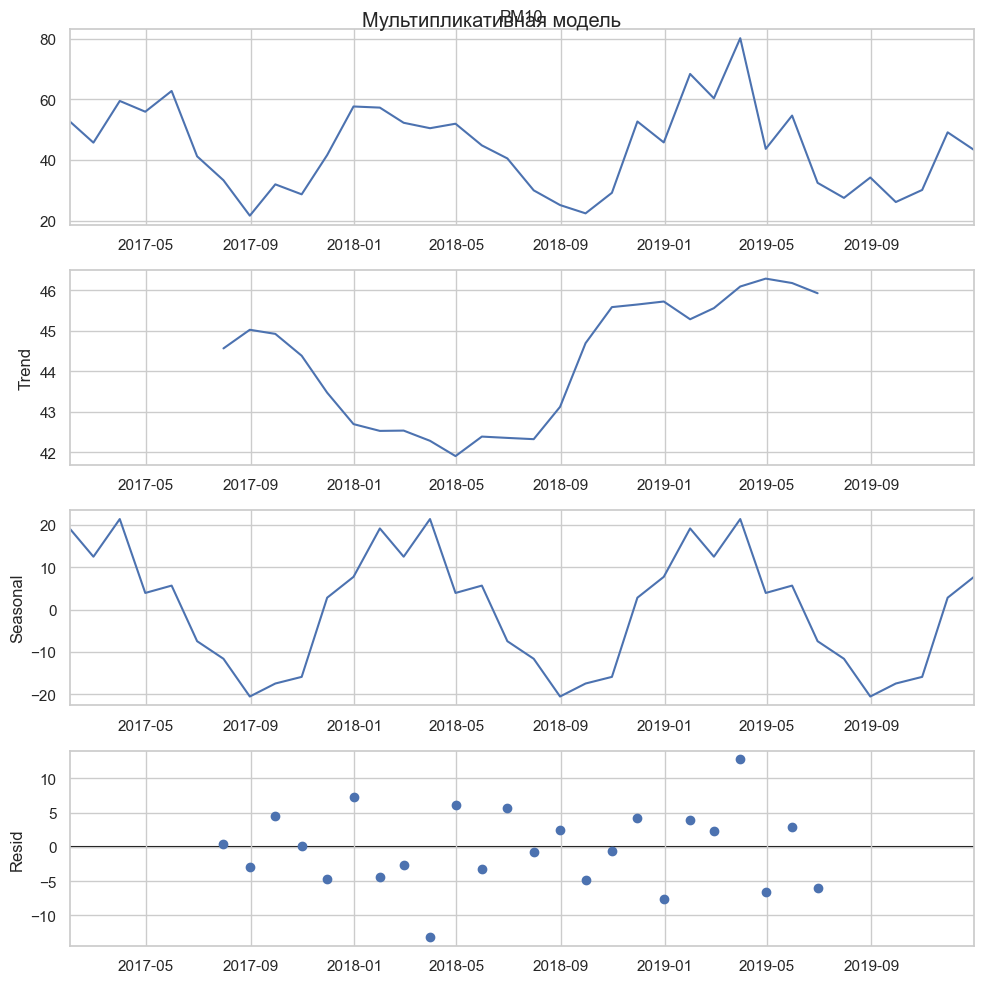

In [260]:
# декомпозиция
result_A_PM10 = seasonal_decompose(df_PM10_sum.PM10, model='additive', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_A_PM10.plot().suptitle('Аддитивная модель модель')

Text(0.5, 0.98, 'Аддитивная модель модель')

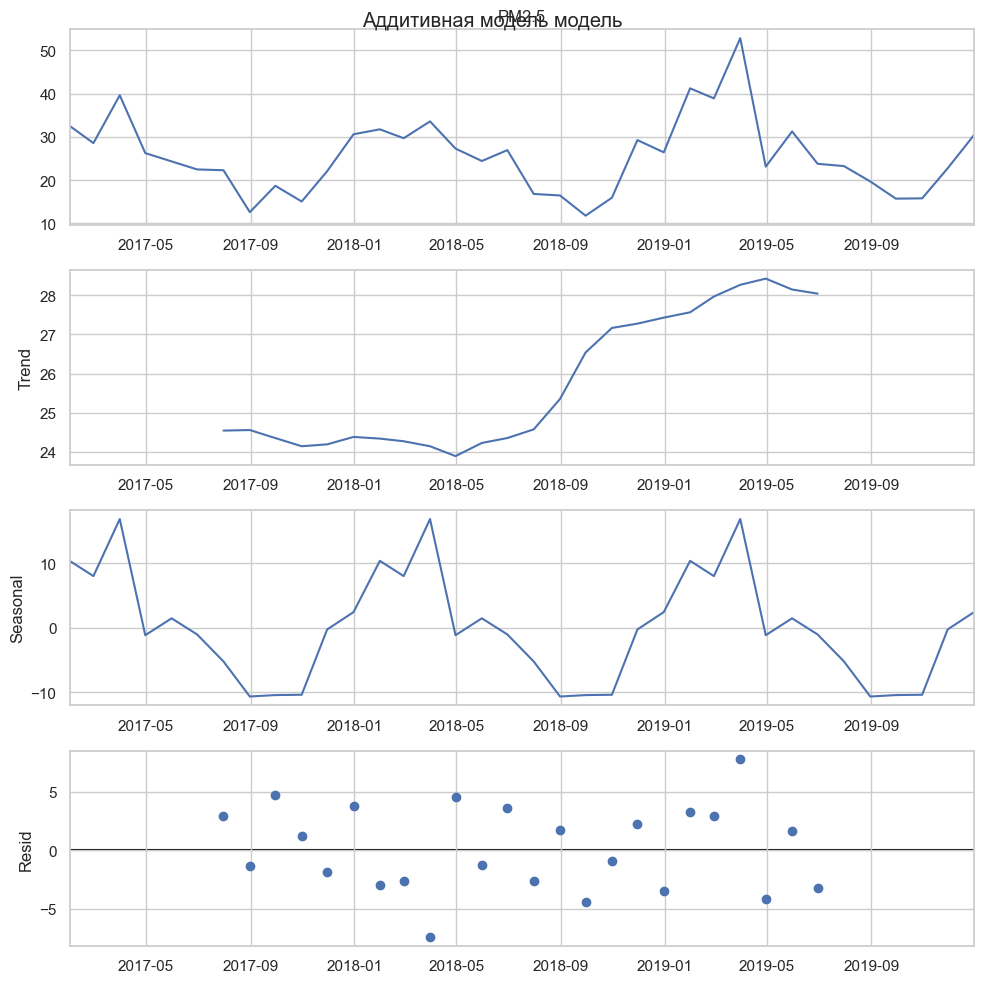

In [261]:
# декомпозиция
result_A_PM2_5 = seasonal_decompose(df_PM2_5_sum['PM2.5'], model='additive', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_A_PM2_5.plot().suptitle('Аддитивная модель модель')

In [268]:
fit_PM10 = ExponentialSmoothing(df_PM10_sum, seasonal_periods=12, trend='mul', seasonal='add').fit()

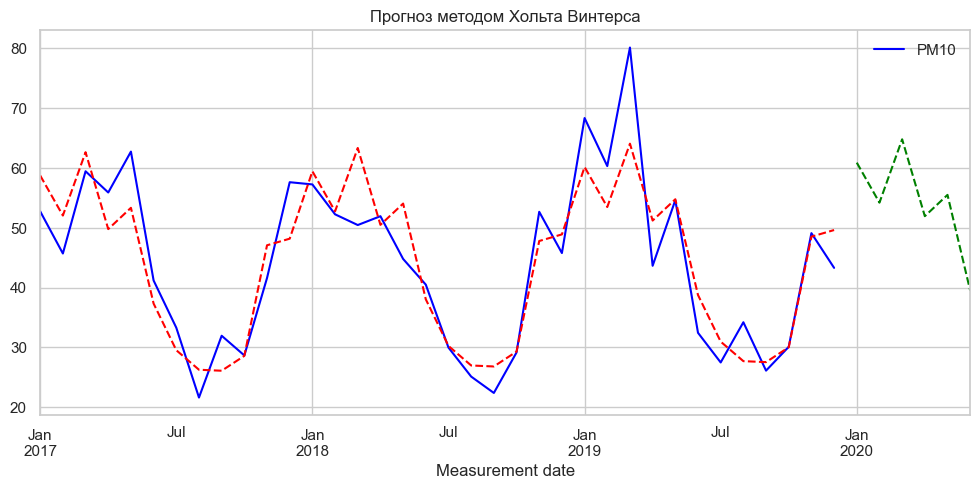

In [269]:
ax = df_PM10_sum.plot(figsize=(12,5), color='blue', title="Прогноз методом Хольта Винтерса" )
fit_PM10.fittedvalues.plot(ax=ax, style='--', color='red')
fit_PM10.forecast(6).plot(ax=ax, style='--', color='green')
plt.show()

In [2]:
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [280]:
df_CO_sum.reset_index(inplace=True)
df_CO_sum.columns =['ds', 'y']
df_CO_sum.head()

,ds,y
0,2017-01-31,0.702651
1,2017-02-28,0.634208
2,2017-03-31,0.591720
3,2017-04-30,0.504556
4,2017-05-31,0.431543


In [4]:
m = Prophet(interval_width=0.97, seasonality_prior_scale=12)
model = m.fit(df_CO_sum)

NameError: name 'df_CO_sum' is not defined

In [ ]:
future = m.make_future_dataframe(periods=6, freq='MS')
forecast_fb = m.predict(future)
forecast_fb.tail(6)

In [ ]:
forecast_fb[['ds', 'yhat']]

In [ ]:
plot1 = m.plot(forecast_fb)

In [126]:
# Select the columns of interest
so2 = df_sum_ser['SO2']
no2 = df_sum_ser['NO2']

# Calculate the correlation coefficient
correlation = so2.corr(no2)

# Print the correlation coefficient
print(f"Correlation coefficient between SO2 and NO2: {correlation}")

Correlation coefficient between SO2 and NO2: 0.7438982061904988


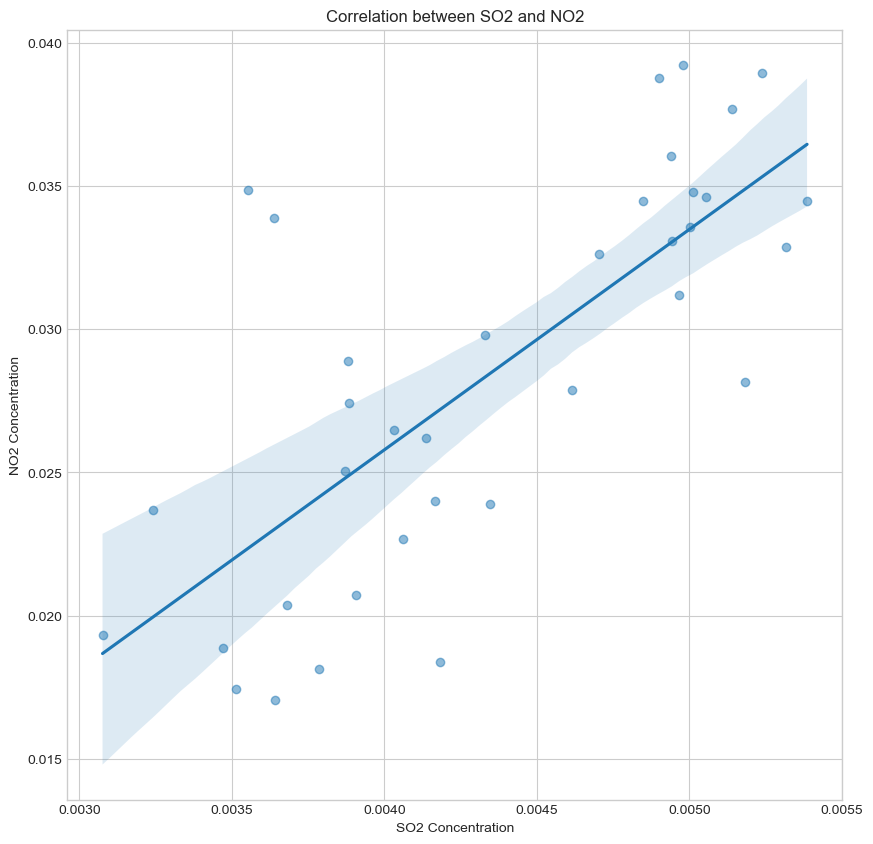

In [128]:
# Create a scatter plot with trendline
sns.regplot(x=so2, y=no2, scatter_kws={'alpha': 0.5})
plt.xlabel('SO2 Concentration')
plt.ylabel('NO2 Concentration')
plt.title('Correlation between SO2 and NO2')
plt.show()

In [230]:
# Load the summary dataset
df_summary = pd.read_csv('Measurement_summary.csv')

# Loop through columns and replace negative values with zero
for col in df_summary.columns[5:10]:  # Adjust the column range as per your data
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')  # Convert column to numeric type
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero

# Convert 'Measurement date' to datetime
df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])

# Resample to monthly frequency and apply mean to pollutants
df_monthly_mean = df_summary.set_index('Measurement date').resample('M')[['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].mean()

# Create a new DataFrame for resampled 'Station code' column
df_station_code = df_summary.set_index('Measurement date')['Station code'].resample('M').first()

# Merge the resampled dataframes
df_monthly_summary = pd.concat([df_station_code, df_monthly_mean], axis=1)

# Define the air quality thresholds
thresholds = {
    'SO2': [0.002, 0.005, 0.015, 0.1],
    'NO2': [0.03, 0.06, 0.2, 2.0],
    'CO': [2.0, 9.0, 15.0, 50.0],
    'O3': [0.03, 0.09, 0.15, 0.5],
    'PM10': [30.0, 80.0, 150.0, 600.0],
    'PM2.5': [15.0, 35.0, 75.0, 500.0]
}

# Function to assign colors based on thresholds
def assign_color(value, thresholds):
    if value >= 0 and value < thresholds[1]:
        return 'blue'
    elif value < thresholds[2] and value >= thresholds[1]:
        return 'green'
    elif value < thresholds[3] and value >= thresholds[2]:
        return 'yellow'
    elif value >= thresholds[3]:
        return 'red'

# Iterate over the pollutant columns and assign colors
for pollutant in thresholds.keys():
    threshold_values = thresholds[pollutant]
    color_column = f'{pollutant} Color'
    df_monthly_summary[color_column] = df_monthly_summary[pollutant].apply(lambda x: assign_color(x, threshold_values))


In [231]:
df_monthly_summary.head()

,Station code,SO2,NO2,O3,CO,PM10,PM2.5,SO2 Color,NO2 Color,CO Color,O3 Color,PM10 Color,PM2.5 Color
Measurement date,,,,,,,,,,,,,
2017-01-31,101,0.005012,0.034788,0.014110,0.702651,52.752366,32.525000,green,blue,blue,blue,blue,blue
2017-02-28,101,0.005055,0.034625,0.018249,0.634208,45.703214,28.545179,green,blue,blue,blue,blue,blue
2017-03-31,101,0.005140,0.037669,0.024718,0.591720,59.455914,39.610376,green,blue,blue,blue,blue,green
2017-04-30,101,0.004966,0.031194,0.034605,0.504556,55.906278,26.233000,blue,blue,blue,blue,blue,blue
2017-05-31,101,0.005183,0.028162,0.038675,0.431543,62.747097,24.309946,green,blue,blue,blue,blue,blue


In [237]:
# Define the pollutants
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

# Iterate over each pollutant
for pollutant in pollutants:
    # Count the occurrences of red, blue, yellow, and green values for each station code
    red_counts = df_monthly_summary[df_monthly_summary[f'{pollutant} Color'] == 'red']['Station code'].value_counts()
    blue_counts = df_monthly_summary[df_monthly_summary[f'{pollutant} Color'] == 'blue']['Station code'].value_counts()
    yellow_counts = df_monthly_summary[df_monthly_summary[f'{pollutant} Color'] == 'yellow']['Station code'].value_counts()
    green_counts = df_monthly_summary[df_monthly_summary[f'{pollutant} Color'] == 'green']['Station code'].value_counts()

    # Find the station codes with the maximum count of red, blue, yellow, and green values

    if not blue_counts.empty:
        station_with_most_blue = blue_counts.idxmax()
        print(f"Station code with the most blue values for {pollutant}: {station_with_most_blue}")
    else:
        print(f"No station code has blue values for {pollutant}.")

    if not green_counts.empty:
        station_with_most_green = green_counts.idxmax()
        print(f"Station code with the most green values for {pollutant}: {station_with_most_green}")
    else:
        print(f"No station code has green values for {pollutant}.")

    if not yellow_counts.empty:
        station_with_most_yellow = yellow_counts.idxmax()
        print(f"Station code with the most yellow values for {pollutant}: {station_with_most_yellow}")
    else:
        print(f"No station code has yellow values for {pollutant}.")

    if not red_counts.empty:
        station_with_most_red = red_counts.idxmax()
        print(f"Station code with the most red values for {pollutant}: {station_with_most_red}")
    else:
        print(f"No station code has red values for {pollutant}.")

    print()


Station code with the most blue values for SO2: 101
Station code with the most green values for SO2: 101
No station code has yellow values for SO2.
No station code has red values for SO2.

Station code with the most blue values for NO2: 101
No station code has green values for NO2.
No station code has yellow values for NO2.
No station code has red values for NO2.

Station code with the most blue values for O3: 101
No station code has green values for O3.
No station code has yellow values for O3.
No station code has red values for O3.

Station code with the most blue values for CO: 101
No station code has green values for CO.
No station code has yellow values for CO.
No station code has red values for CO.

Station code with the most blue values for PM10: 101
Station code with the most green values for PM10: 101
No station code has yellow values for PM10.
No station code has red values for PM10.

Station code with the most blue values for PM2.5: 101
Station code with the most green value

<Figure size 1000x600 with 0 Axes>

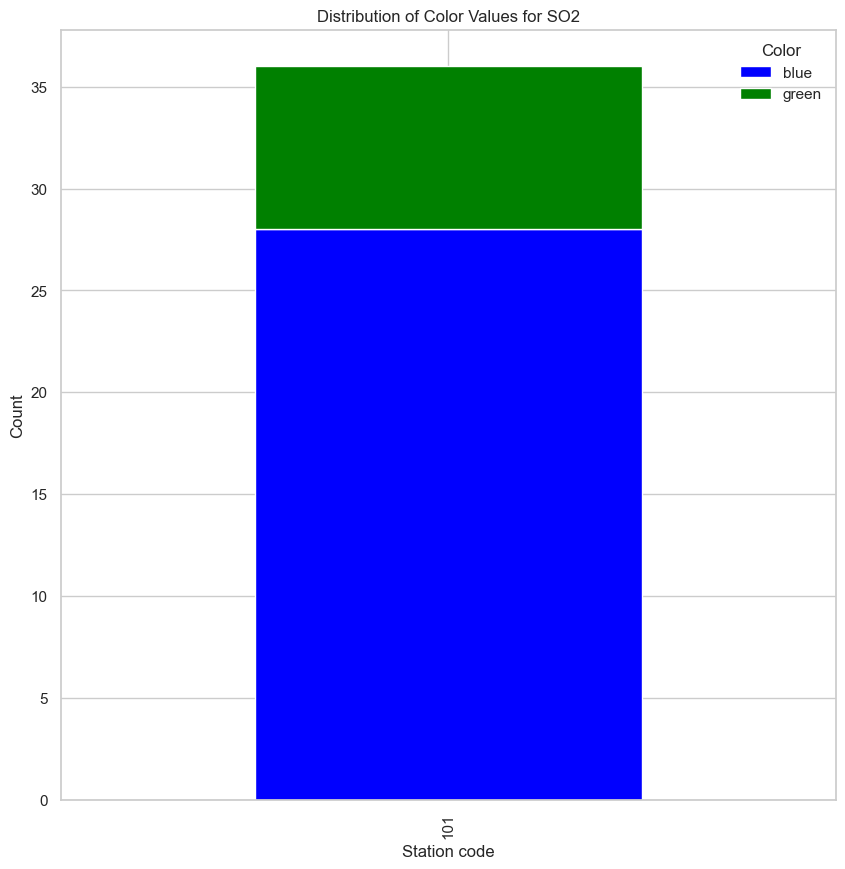

<Figure size 1000x600 with 0 Axes>

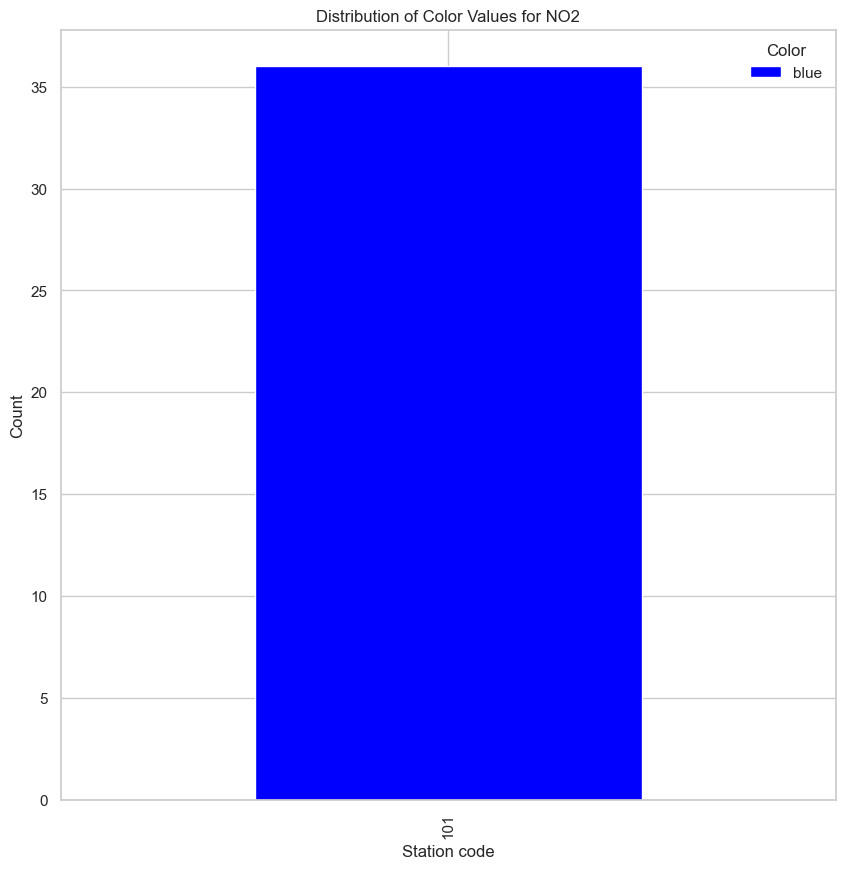

<Figure size 1000x600 with 0 Axes>

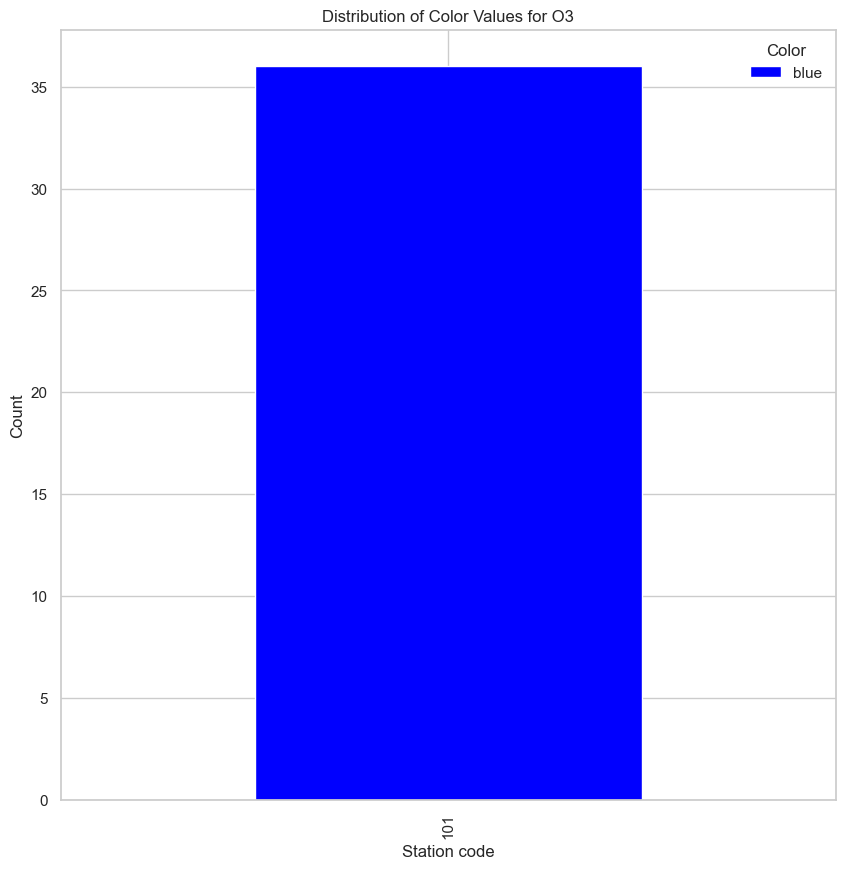

<Figure size 1000x600 with 0 Axes>

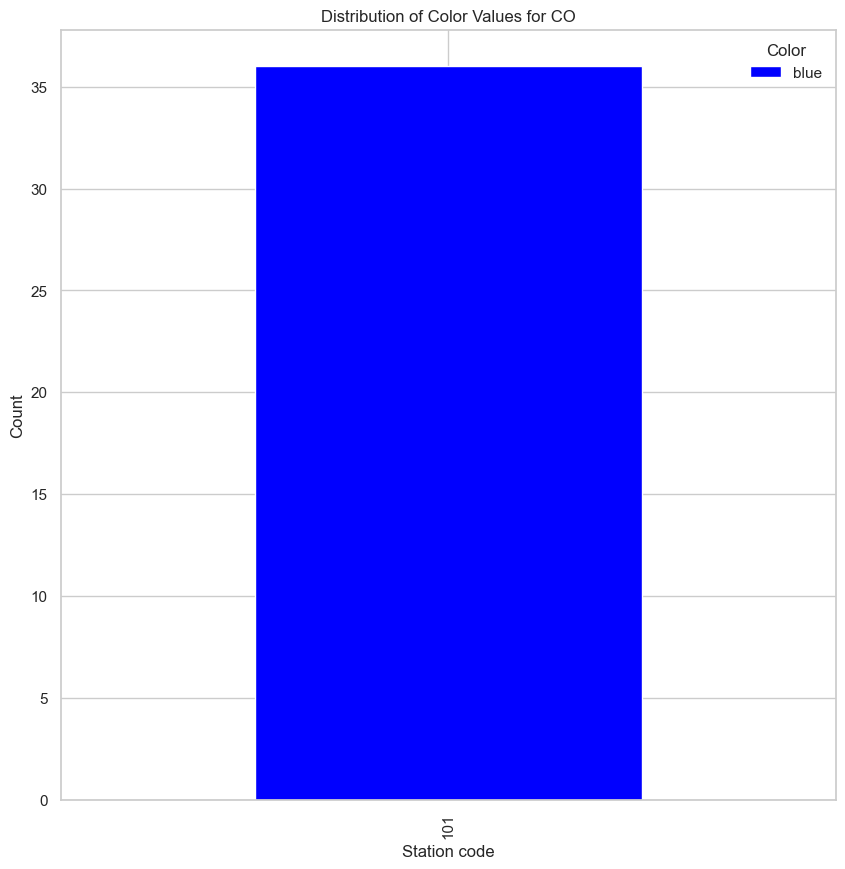

<Figure size 1000x600 with 0 Axes>

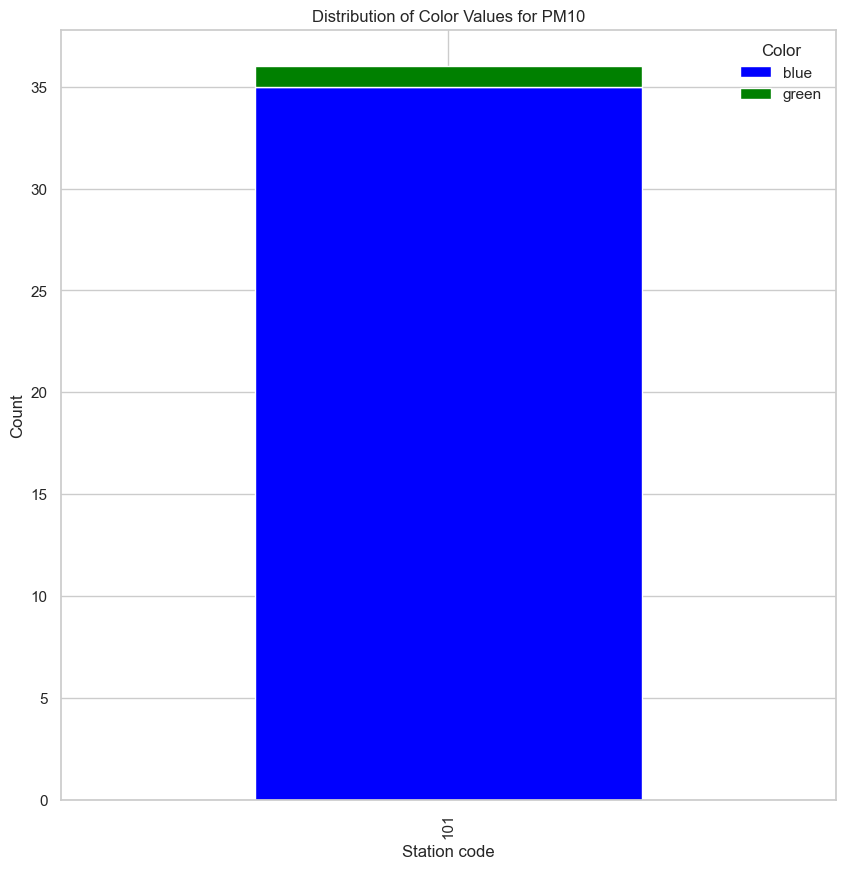

<Figure size 1000x600 with 0 Axes>

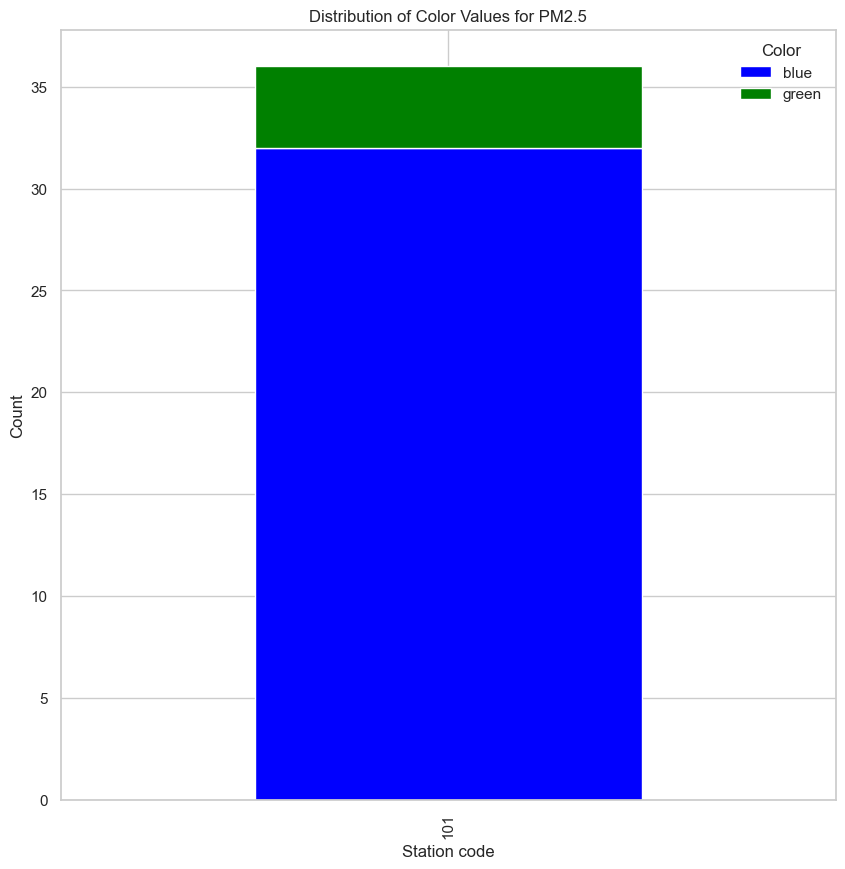

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset of the dataframe with relevant columns
df_color_counts = df_monthly_summary[['Station code', 'SO2 Color', 'NO2 Color', 'O3 Color', 'CO Color', 'PM10 Color', 'PM2.5 Color']]

# Set the order of color categories for the legend
color_order = ['blue', 'green', 'yellow', 'red']

# Iterate over each pollutant
for pollutant in pollutants:
    # Create a cross-tabulation of station codes and color values
    color_table = pd.crosstab(df_color_counts['Station code'], df_color_counts[f'{pollutant} Color'])

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))
    color_table.plot(kind='bar', stacked=True, color=color_order)
    plt.xlabel('Station code')
    plt.ylabel('Count')
    plt.title(f'Distribution of Color Values for {pollutant}')
    plt.legend(title='Color', loc='upper right', labels=color_order)
    plt.show()
